### Name: Paul Hickey
### ID: 22267964

Open a new Jupyter notebook and name it etivity2.ipynb. In your notebook, load bank.csv into a Pandas dataframe. Follow the examples and process in Lab 2 - Data Preparation.ipynb to prepare bank.csv for machine learning.

Ensure that you have:

- encoded all categorical attributes as numerical,
- filled in all missing values
- applied a scaler to rescale features
- treated outliers appropriately
- created at least one new feature from the existing ones

Shortly describe and Justify the data preparation choices you have taken in markdown cells. Aim at not having markdown cells longer than 2-3 lines of text.

In the end, save the prepared dataset as a CSV file on your hard disk.

# 1. Import modules and data

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Load the data
df = pd.read_csv("./bank.csv")
df.head()

age          job   marital  education default  balance housing loan  \
0  32.0   technician    single   tertiary      no      392     yes   no   
1  39.0   technician  divorced  secondary      no      688     yes  yes   
2  59.0      retired   married  secondary      no     1035     yes  yes   
3  47.0  blue-collar   married  secondary      no      398     yes  yes   
4  54.0      retired   married  secondary      no     1004     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome  \
0  cellular    1   apr       957         2    131         2  failure   
1  cellular    1   apr       233         2    133         1  failure   
2  cellular    1   apr       126         2    239         1  failure   
3  cellular    1   apr       274         1    238         2  failure   
4  cellular    1   apr       479         1    307         1  failure   

  subscribed  
0         no  
1         no  
2         no  
3         no  
4         no

In [4]:
df.isna().sum()

age            12
job            10
marital         0
education     104
default         0
balance         0
housing         0
loan            0
contact       191
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome      454
subscribed      0
dtype: int64

In [6]:
df_original = df.copy(deep=True)

## Sanity-check numeric values
We will quickly check that certain features are within appropriate ranges. 
- We would not expect to see negative values for **age** or values over 122 (we can play it safe by using the oldest record age to which a person has lived).
- **day** (day of month) should be in the range 1 to 31.
- **campaign** (number of contacts performed during this campaign) should be 0 or greater.
- **pdays** (number of days that passed by after the client was last contacted from a previous campaign) should be between 0 and 999 (according to the [source documentation](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#)).
- **previous** should be 0 or greater.

In [7]:
df.describe()

age       balance          day     duration     campaign  \
count  1988.000000   2000.000000  2000.000000  2000.000000  2000.000000   
mean     41.753018   1413.663500    13.851500   292.020500     1.909500   
std      12.724358   3131.224213     9.712189   221.557295     1.378862   
min      18.000000   -980.000000     1.000000     7.000000     1.000000   
25%      32.000000    201.500000     5.000000   146.000000     1.000000   
50%      38.000000    551.000000    12.000000   236.000000     1.000000   
75%      50.000000   1644.500000    23.000000   379.000000     2.000000   
max      93.000000  81204.000000    31.000000  1823.000000    11.000000   

             pdays     previous  
count  2000.000000  2000.000000  
mean    167.896000     2.561500  
std     131.754126     3.400735  
min      -1.000000     0.000000  
25%      75.750000     1.000000  
50%     182.000000     2.000000  
75%     251.000000     3.000000  
max     854.000000    55.000000

In [8]:
numeric = df.select_dtypes(['int64', 'float64']).columns.values

### Handle out of range values
We can see from the table above that, for the most part, the data is in order. There is however an unexpected value of **-1** in the **pdays** column. We can have a quick look at the rows in which that value occurs to decide on how to deal with these instances.

In [9]:
count_pdays = (df['pdays'] == -1).sum()
print(f'Instances where pdays is -1 : {count_pdays}')

Instances where pdays is -1 : 454


In [10]:
df.loc[df['pdays'] == -1]

age           job   marital  education default  balance housing loan  \
799   33.0   blue-collar   married    primary     yes     -744     yes   no   
800   60.0       retired   married    primary      no       -2     yes   no   
801   33.0    technician    single   tertiary      no      129     yes   no   
802   33.0      services  divorced  secondary      no      411     yes   no   
803   47.0    management   married   tertiary      no      643     yes   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
1995  20.0       student    single        NaN      no     2785      no   no   
1996  28.0        admin.    single  secondary      no      127      no   no   
1997  81.0       retired   married    primary      no     1154      no   no   
1998  46.0      services   married    primary      no     4343     yes   no   
1999  40.0  entrepreneur   married  secondary      no     6403      no   no   

        contact  day month  duration  campaign  pdays  previous poutcome  \
799         NaN    8   may       206         1     -1         0      NaN   
800         NaN    8   may        75         1     -1         0      NaN   
801         NaN    8   may       128         1     -1         0      NaN   
802         NaN    8   may       216         1     -1         0      NaN   
803         NaN    8   may       155         1     -1         0      NaN   
...         ...  ...   ...       ...       ...    ...       ...      ...   
1995   cellular   16   sep       327         2     -1         0      NaN   
1996   cellular   16   sep      1334         2     -1         0      NaN   
1997  telephone   17   sep       231         1     -1         0      NaN   
1998        NaN   20   sep       185         1     -1         0      NaN   
1999   cellular   22   sep       208         2     -1         0      NaN   

     subscribed  
799          no  
800          no  
801          no  
802          no  
803          no  
...         ...  
1995        yes  
1996        yes  
1997        yes  
1998        yes  
1999        yes  

[454 rows x 17 columns]

We can see now that the number of instances where pdays is -1 is the same as the number of missing values for poutcome. According to the documentation, the value pdays=999 implies that a client was not contacted in a previous campaign. The max-value of pdays in our data however is 854, so it may be that -1 is standing for 999. Further evidence to support this appears in the comparison below, where we seee a correlation between these instances of pdays=-1 and missing information on prior campaigns (*poutcome*).

In [11]:
# Check for correlation between pdays=-1 and poutcome=NaN
count_pdays_poutcome = ((df['pdays'] == -1) & (df['poutcome'] == None)).sum()
print(f'Instances where pdays is -1 and poutcome is missing : {count_pdays}')

Instances where pdays is -1 and poutcome is missing : 454


As there is a correlation between the poutcome and pdays features where values are missing, we can potentially leave the value pdays = -1 and then encode the NaNs in poutcome as an additional feature. This may provide an adequate pattern from which a model can learn, however this would need to be assessed during experimental model training.

# 2. Handling missing values
We will need to take appropriate steps to handle missing values where they occur. As part of this step we can also consider whether to retain a feature at all. 

In [12]:
# Find the number of nulls/NaNs in the dataset
df.isna().sum()

age            12
job            10
marital         0
education     104
default         0
balance         0
housing         0
loan            0
contact       191
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome      454
subscribed      0
dtype: int64

## Handling missing values in "age"

In [13]:
# Using original data for legibility
df_original[df_original['age'].isna()]

age            job  marital  education default  balance housing loan  \
456   NaN  self-employed  married   tertiary      no      917      no   no   
472   NaN    blue-collar  married    primary      no      474     yes  yes   
526   NaN       services  married  secondary      no     2478     yes   no   
595   NaN     management  married   tertiary      no     1857      no   no   
597   NaN  self-employed  married  secondary     yes      254     yes  yes   
601   NaN         admin.   single  secondary      no      111     yes   no   
605   NaN     management  married   tertiary      no     1330     yes   no   
744   NaN     management  married   tertiary      no      -61      no   no   
795   NaN     technician   single   tertiary      no      992     yes   no   
1171  NaN        retired  married   tertiary      no     2812      no   no   
1232  NaN        student   single  secondary      no      431      no   no   
1408  NaN  self-employed   single   tertiary      no      251      no   no   

        contact  day month  duration  campaign  pdays  previous poutcome  \
456    cellular    6   feb       518         3    212         5  failure   
472   telephone    9   feb       152         3    221         1  failure   
526    cellular   28   jan       347         1    230         1  failure   
595    cellular   29   jan       386         1    168         4  failure   
597    cellular   29   jan       194         1    188         1  failure   
601    cellular   29   jan        55         1    195         3  failure   
605    cellular   29   jan        41         2    261         1  failure   
744    cellular   30   jan        90         5    172         1  failure   
795    cellular    4   may       301         1     88         2  success   
1171   cellular    3   aug       392         4    181         3  success   
1232   cellular   19   aug       418        11    185         5  success   
1408   cellular   12   jul       537         1     -1         0      NaN   

     subscribed  
456          no  
472          no  
526          no  
595          no  
597          no  
601          no  
605          no  
744          no  
795          no  
1171        yes  
1232        yes  
1408        yes

From the table above we can see additional details for the clients for whom age has not been recorded. This provides us with some options for how to impute the missing values.

We can see that one of the clients is retired. Assuming that they retired at the normal retirement age in Portugal (where the data was collected), this puts them at or above 66 years. We can use the mean age in the data for clients over 66 to fill this value, which is 74 years (as calculated below).

In [14]:
mean_over_66 = int( np.round( (df[df['age'] > 66]['age']).mean() ) )
print(f'Mean age over 66: {mean_over_66}')

Mean age over 66: 74


In [15]:
# Replace missing retiree age
df.loc[(df_original['age'].isna()) & (df_original['job'] == 'retired'), 'age'] = mean_over_66

For the other ages, we will simply impute them with the median age of the general client population.

In [16]:
df['age'].fillna(df['age'].median(), inplace=True)

## Handling missing values in "education"
Education is an ordinal feature. The breakdown across its categories is as follows:

|primary|secondary|tertiary|missing values|
|---|---|---|---|
|217|995|684|104|



In [17]:
df[df['education'].isna()]

age          job  marital education default  balance housing loan  \
10    38.0   management   single       NaN      no      715     yes   no   
15    38.0  blue-collar  married       NaN      no        0     yes   no   
124   39.0  blue-collar  married       NaN      no        0      no   no   
209   37.0   management  married       NaN      no      247      no   no   
257   46.0          NaN  married       NaN      no      677      no   no   
...    ...          ...      ...       ...     ...      ...     ...  ...   
1944  39.0   management  married       NaN      no       76      no   no   
1972  29.0   unemployed   single       NaN      no     1584      no   no   
1985  21.0      student   single       NaN      no     1506      no   no   
1993  35.0   management  married       NaN      no     2326     yes  yes   
1995  20.0      student   single       NaN      no     2785      no   no   

       contact  day month  duration  campaign  pdays  previous poutcome  \
10    cellular    2   apr       951         1    132         3  failure   
15    cellular    2   apr       477         2    267         1  failure   
124   cellular    2   feb       731         1    193         3  failure   
209   cellular    2   feb       192         2    208         1  failure   
257   cellular    3   feb       425         1     82         1  failure   
...        ...  ...   ...       ...       ...    ...       ...      ...   
1944  cellular   15   sep       200         1    183         1  success   
1972  cellular    6   sep       245         1     -1         0      NaN   
1985  cellular   14   sep       340         1     -1         0      NaN   
1993  cellular   16   sep       319         1     -1         0      NaN   
1995  cellular   16   sep       327         2     -1         0      NaN   

     subscribed  
10           no  
15           no  
124          no  
209          no  
257          no  
...         ...  
1944        yes  
1972        yes  
1985        yes  
1993        yes  
1995        yes  

[104 rows x 17 columns]

From previous explorations, the main correlation we found between education level and another feature was in the **job** attribute. This is highlighted again below. We can see that a significant majority of clients in *management* jobs have a third level education. Management roles also account for over 23% of all jobs.

In [18]:
df.job.value_counts(ascending=True)

housemaid         35
entrepreneur      45
self-employed     64
unemployed        69
student           96
retired          162
services         165
admin.           247
blue-collar      298
technician       348
management       461
Name: job, dtype: int64

In [19]:
def groupedEducationPlot(feature, title):
    chart_freqs = pd.DataFrame()

    chart_freqs['Primary'] = df_original[df_original['education'] == 'primary'][feature].value_counts()
    chart_freqs['Secondary'] = df_original[df_original['education'] == 'secondary'][feature].value_counts()
    chart_freqs['Tertiary'] = df_original[df_original['education'] == 'tertiary'][feature].value_counts()

    chart_freqs.plot.bar(title = title, figsize=(12,8), rot=45)

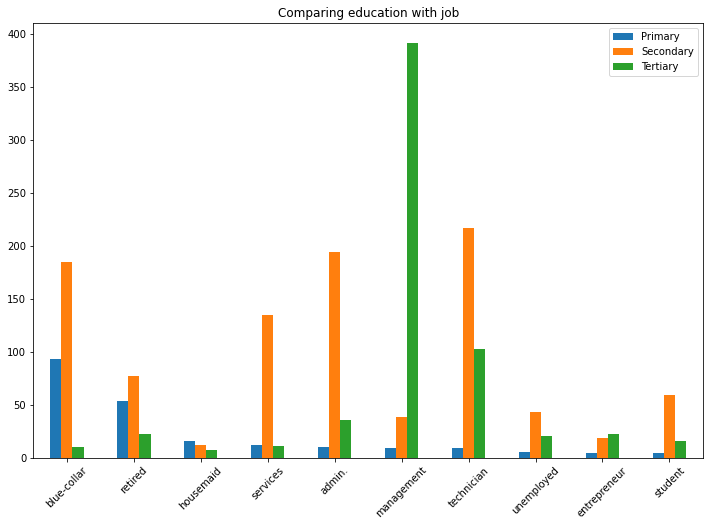

In [20]:
groupedEducationPlot('job', 'Comparing education with job')

Based on the above, it is reasonable to fill missing values in education with *tertiary* where a client's job is *management*.

In [21]:
df.loc[(df['job'] == 'management') & (df['education'].isna()), 'education'] = 'tertiary'

As we have used the job feature as the basis for an imputing strategy above, we will continue to use it for the remaining values. As we can see from the histogram, *entrepreneur* is the only category where *primary* education dominates, so we will see if there are any entrepreneurs with missing educational status.

In [22]:
df[df['education'].isna() & (df['job'] == 'entrepreneur')]

age           job  marital education default  balance housing loan  \
815  36.0  entrepreneur  married       NaN      no      298     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome  \
815     NaN    8   may       215         1     -1         0      NaN   

    subscribed  
815         no

As there is only one client with this status, we will set their education to *primary*.

In [23]:
df.loc[(df['job'] == 'entrepreneur') & (df['education'].isna()), 'education'] = 'primary'

In [24]:
df['education'].value_counts(ascending=True)

primary      218
tertiary     707
secondary    995
Name: education, dtype: int64

In [25]:
df[df['education'].isna()].shape[0]

80

For the remaining missing data we will use the mode value of *secondary*.

In [26]:
df['education'].fillna('secondary', inplace=True)

## Handling missing values in "contact"
The breakdown for contact is as follows:

|telephone|cellular|missing values|
|---|---|---|
|146|1663|191|

As we can see, approximately 83% of clients were contacted on cell phone. The number of missing values is greater than the number of clients recorded as *contacted by telephone*. In a comparison of these values against whether the client subscribed (shown below), we can see ~53% of those contacted by *cellular* subscribed and ~62% of those contacted by *telephone* subscribed. Given that only 13% of the unknowns subscribed, it is unclear how we might impute this figure.

In [27]:
df['contact'].fillna('unknown', inplace=True)

In [28]:
contact_group = df.groupby('subscribed', axis=0)
contact_group.contact.value_counts()

subscribed  contact  
no          cellular     778
            unknown      167
            telephone     55
yes         cellular     885
            telephone     91
            unknown       24
Name: contact, dtype: int64

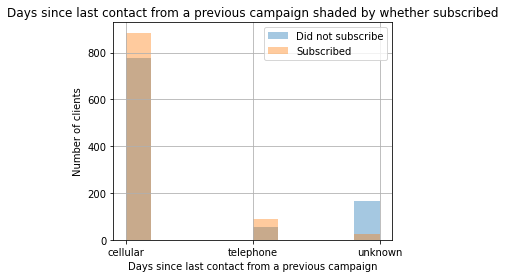

In [29]:
plt.figure(figsize=(5,4))
contact_group.contact.hist(alpha=0.4)
plt.title('Days since last contact from a previous campaign shaded by whether subscribed')
plt.xlabel('Days since last contact from a previous campaign')
# plt.xlim(0)
plt.ylabel('Number of clients')
plt.legend(['Did not subscribe', 'Subscribed'])

One thing we don't know is whether a client was contacted by telephone or cellular as an option or because it was the only mode of contact available for that client. If we knew this, it might enable some inference about phone ownership per demographic and could bear investigation. For now however, based on the above, we will drop this feature.

In [30]:
df.drop('contact', axis=1, inplace=True)

## Handling missing values in "job"

In [31]:
df[df['job'].isna()]

age  job  marital  education default  balance housing loan  day month  \
255   42.0  NaN   single    primary      no     2398     yes   no    3   feb   
257   46.0  NaN  married  secondary      no      677      no   no    3   feb   
831   41.0  NaN   single    primary      no     2398     yes   no    8   may   
1223  55.0  NaN  married  secondary      no     2206      no   no   12   aug   
1281  50.0  NaN  married  secondary      no      558      no   no    9   jul   
1669  54.0  NaN  married  secondary      no     2206      no   no   13   may   
1711  77.0  NaN  married  secondary      no      397      no   no    7   may   
1801  28.0  NaN   single  secondary      no      326      no   no   11   oct   
1868  48.0  NaN   single  secondary      no     1819      no   no    2   sep   
1975  45.0  NaN  married   tertiary      no      406      no   no    7   sep   

      duration  campaign  pdays  previous poutcome subscribed  
255        144         2    271         2  failure         no  
257        425         1     82         1  failure         no  
831        287         2     -1         0      NaN         no  
1223       265         1     91         5  success        yes  
1281       464         1    683         6  failure        yes  
1669       260         1     91         4  success        yes  
1711       300         3     -1         0      NaN        yes  
1801       450         1    231         1  success        yes  
1868      1440         1    458         1  failure        yes  
1975       314         1     -1         0      NaN        yes

We can begin here by setting the client who is 77 years old to *retired*, which is a likely value.

In [34]:
df.loc[(df['age'] > 66) & (df['job'].isna()), 'job'] = 'retired'

Next we can set the client with tertiary education to *management* based on what we've previously seen on the relationship between these variables.

In [35]:
df.loc[(df['education'] == 'tertiary') & (df['job'].isna()), 'job'] = 'management'

In [36]:
def groupedJobPlot(feature, title):
    chart_freqs = pd.DataFrame()
    jobs = ['housemaid', 'entrepreneur', 'self-employed', 'unemployed', 'student', 'retired', 'services', 'admin.', 'blue-collar', 'technician', 'management']
    for job in jobs:
        chart_freqs[job] = df_original[df_original['job'] == job][feature].value_counts()

    chart_freqs.plot.bar(title = title, figsize=(12,8), rot=45)

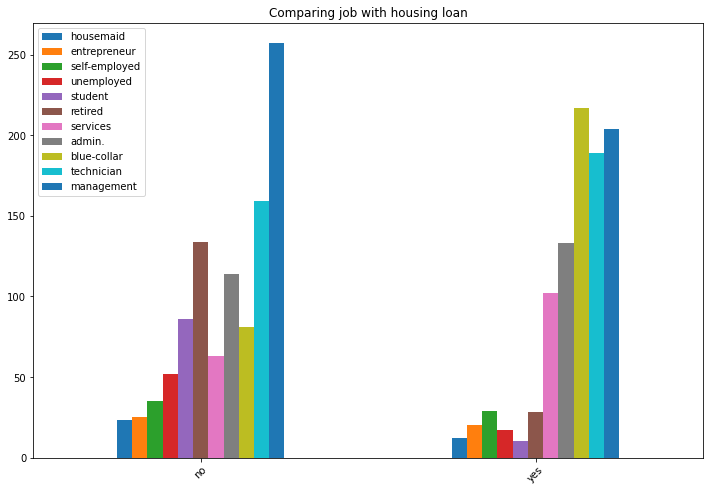

In [37]:
groupedJobPlot('housing', 'Comparing job with housing loan')

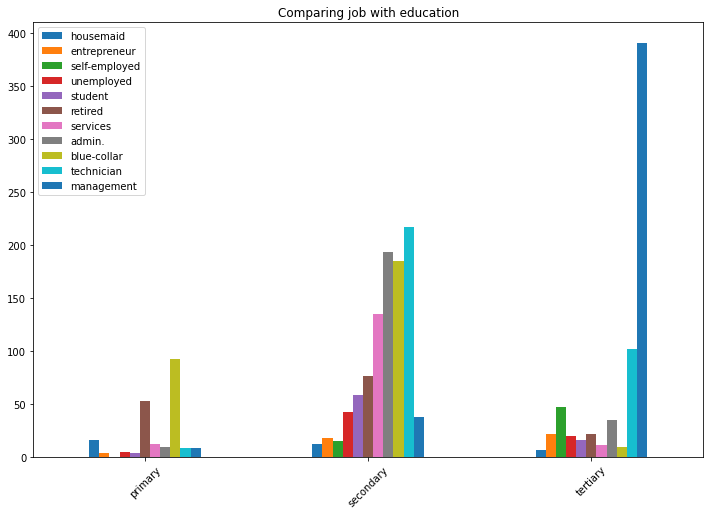

In [38]:
groupedJobPlot('education', 'Comparing job with education')

We can see from the above that *blue-collar* has the highest incidences of *housing = yes* and *education = primary* so the two features with those values can be filled with *job = blue-collar*.

In [39]:
df.loc[(df['education'] == 'primary') & (df['housing'] == 'yes') & (df['job'].isna()), 'job'] = 'blue-collar'

Let's take look at the remaining missing values in **job**

In [40]:
df[df['job'].isna()]

age  job  marital  education default  balance housing loan  day month  \
257   46.0  NaN  married  secondary      no      677      no   no    3   feb   
1223  55.0  NaN  married  secondary      no     2206      no   no   12   aug   
1281  50.0  NaN  married  secondary      no      558      no   no    9   jul   
1669  54.0  NaN  married  secondary      no     2206      no   no   13   may   
1801  28.0  NaN   single  secondary      no      326      no   no   11   oct   
1868  48.0  NaN   single  secondary      no     1819      no   no    2   sep   

      duration  campaign  pdays  previous poutcome subscribed  
257        425         1     82         1  failure         no  
1223       265         1     91         5  success        yes  
1281       464         1    683         6  failure        yes  
1669       260         1     91         4  success        yes  
1801       450         1    231         1  success        yes  
1868      1440         1    458         1  failure        yes

In [41]:
job_group_1 = [(df['education'] == 'secondary') 
   & (df['marital'] == 'married') 
   & (df['balance'] > 2200) 
   & (df['age'] < 56) 
   & (df['age'] > 27)
   & (df['subscribed'] == 'yes')
   & (df['housing'] == 'no')
   & (df['loan'] == 'no')]

In [42]:
df[job_group_1[0]].job.value_counts()

admin.          11
technician       7
services         5
management       2
blue-collar      1
retired          1
entrepreneur     1
Name: job, dtype: int64

Based on the above, we can reasonably encode this group as *job = admin.*

In [44]:
df.loc[job_group_1[0] & (df['job'].isna()), 'job'] = 'admin.'

In [45]:
job_group_2 = [(df['education'] == 'secondary') 
   & (df['balance'] > 325) 
   & (df['balance'] < 680)  
   & (df['age'] < 56) 
   & (df['age'] > 27)
   & (df['subscribed'] == 'yes')
   & (df['housing'] == 'no')
   & (df['loan'] == 'no')]
df[job_group_2[0]].job.value_counts()

admin.          14
management       5
technician       5
services         5
student          3
blue-collar      2
entrepreneur     1
Name: job, dtype: int64

Based on the above, it also reasonable to encode this other group as *job = admin.*

In [46]:
df.loc[job_group_2[0] & (df['job'].isna()), 'job'] = 'admin.'

In [47]:
df[df['job'].isna()]

age  job  marital  education default  balance housing loan  day month  \
257   46.0  NaN  married  secondary      no      677      no   no    3   feb   
1868  48.0  NaN   single  secondary      no     1819      no   no    2   sep   

      duration  campaign  pdays  previous poutcome subscribed  
257        425         1     82         1  failure         no  
1868      1440         1    458         1  failure        yes

In [48]:
job_group_3 = [(df['education'] == 'secondary')  
   & (df['balance'] < 1820)  
   & (df['age'] < 49) 
   & (df['age'] > 45)
   & (df['housing'] == 'no')
   & (df['loan'] == 'no')]
df[job_group_3[0]].job.value_counts()

admin.           5
services         4
technician       4
self-employed    2
blue-collar      2
unemployed       2
housemaid        2
entrepreneur     1
student          1
Name: job, dtype: int64

In fact, it looks like the 3 groups could be acceptably encoded as *job = admin.*. 

In [49]:
df.loc[job_group_3[0] & (df['job'].isna()), 'job'] = 'admin.'

In [50]:
# Check all missing values handled
df.isna().sum()

age             0
job             0
marital         0
education       0
default         0
balance         0
housing         0
loan            0
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome      454
subscribed      0
dtype: int64

As we can see only *poutcome* still has empty values, which we will encode as they are, as highlighted earlier.

# 3. Process categorical features

## Encode month feature
We will encode both the month of the year and the day of the month as cyclical features, to retain the *distance* relationship that exists between each month from year to year and each day from month to month.

For this encoding, we will first need to map the month values to integers 0 to 11.

In [51]:
month_map = {
    'jan': 0,
    'feb': 1,
    'mar': 2,
    'apr': 3,
    'may': 4,
    'jun': 5,
    'jul': 6,
    'aug': 7,
    'sep': 8,
    'oct': 9,
    'nov': 10,
    'dec': 11,
}

In [52]:
df['month'] = df['month'].replace(month_map)

In [53]:
df['day_sin'] = np.sin(df.day*(2.*np.pi/31))
df['day_cos'] = np.cos(df.day*(2.*np.pi/31))
df['month_sin'] = np.sin((df.month-1)*(2.*np.pi/12))
df['month_cos'] = np.cos((df.month-1)*(2.*np.pi/12))

In [54]:
df.drop('day', axis=1, inplace=True)
df.drop('month', axis=1, inplace=True)

In [55]:
df.head()

age          job   marital  education default  balance housing loan  \
0  32.0   technician    single   tertiary      no      392     yes   no   
1  39.0   technician  divorced  secondary      no      688     yes  yes   
2  59.0      retired   married  secondary      no     1035     yes  yes   
3  47.0  blue-collar   married  secondary      no      398     yes  yes   
4  54.0      retired   married  secondary      no     1004     yes   no   

   duration  campaign  pdays  previous poutcome subscribed   day_sin  day_cos  \
0       957         2    131         2  failure         no  0.201299  0.97953   
1       233         2    133         1  failure         no  0.201299  0.97953   
2       126         2    239         1  failure         no  0.201299  0.97953   
3       274         1    238         2  failure         no  0.201299  0.97953   
4       479         1    307         1  failure         no  0.201299  0.97953   

   month_sin  month_cos  
0   0.866025        0.5  
1   0.866025        0.5  
2   0.866025        0.5  
3   0.866025        0.5  
4   0.866025        0.5

## Encode other categorical features
We'll use one-hot encoding for the remaining categorical features.

In [56]:
# Get the categorical features
categorical = df.select_dtypes(['object']).columns.values

# first one-hot encode the categorical columns with null values
df = pd.get_dummies(df, columns=categorical, 
                        dummy_na=True, 
                        drop_first=True)
df.head()

age  balance  duration  campaign  pdays  previous   day_sin  day_cos  \
0  32.0      392       957         2    131         2  0.201299  0.97953   
1  39.0      688       233         2    133         1  0.201299  0.97953   
2  59.0     1035       126         2    239         1  0.201299  0.97953   
3  47.0      398       274         1    238         2  0.201299  0.97953   
4  54.0     1004       479         1    307         1  0.201299  0.97953   

   month_sin  month_cos  ...  default_nan  housing_yes  housing_nan  loan_yes  \
0   0.866025        0.5  ...            0            1            0         0   
1   0.866025        0.5  ...            0            1            0         1   
2   0.866025        0.5  ...            0            1            0         1   
3   0.866025        0.5  ...            0            1            0         1   
4   0.866025        0.5  ...            0            1            0         0   

   loan_nan  poutcome_other  poutcome_success  poutcome_nan  subscribed_yes  \
0         0               0                 0             0               0   
1         0               0                 0             0               0   
2         0               0                 0             0               0   
3         0               0                 0             0               0   
4         0               0                 0             0               0   

   subscribed_nan  
0               0  
1               0  
2               0  
3               0  
4               0  

[5 rows x 38 columns]

In [57]:
# now one-hot encode all other categorical columns
df = pd.get_dummies(df, drop_first=True)
df.head()

age  balance  duration  campaign  pdays  previous   day_sin  day_cos  \
0  32.0      392       957         2    131         2  0.201299  0.97953   
1  39.0      688       233         2    133         1  0.201299  0.97953   
2  59.0     1035       126         2    239         1  0.201299  0.97953   
3  47.0      398       274         1    238         2  0.201299  0.97953   
4  54.0     1004       479         1    307         1  0.201299  0.97953   

   month_sin  month_cos  ...  default_nan  housing_yes  housing_nan  loan_yes  \
0   0.866025        0.5  ...            0            1            0         0   
1   0.866025        0.5  ...            0            1            0         1   
2   0.866025        0.5  ...            0            1            0         1   
3   0.866025        0.5  ...            0            1            0         1   
4   0.866025        0.5  ...            0            1            0         0   

   loan_nan  poutcome_other  poutcome_success  poutcome_nan  subscribed_yes  \
0         0               0                 0             0               0   
1         0               0                 0             0               0   
2         0               0                 0             0               0   
3         0               0                 0             0               0   
4         0               0                 0             0               0   

   subscribed_nan  
0               0  
1               0  
2               0  
3               0  
4               0  

[5 rows x 38 columns]

# 4. Feature scaling
Some of the features will need to be rescaled in order to make them useable within a learning model.

The boxplots below will give us a sense of which features have very significant outliers.

<AxesSubplot:>

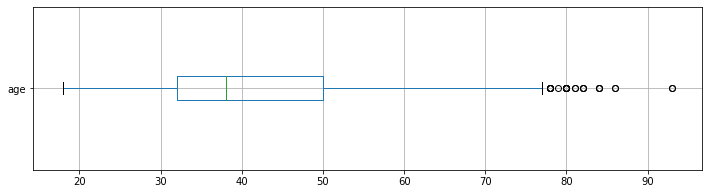

In [58]:
df.boxplot('age', figsize=(12,3), vert=False)

<AxesSubplot:>

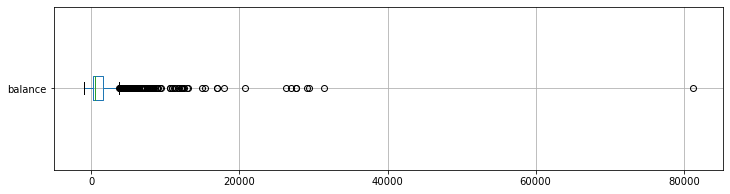

In [59]:
df.boxplot('balance', figsize=(12,3), vert=False)

<AxesSubplot:>

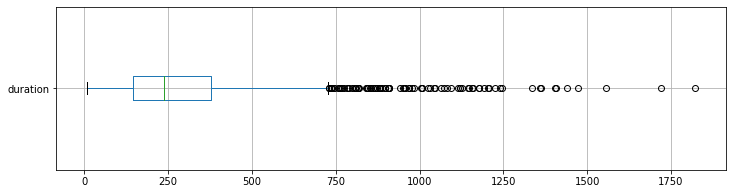

In [60]:
df.boxplot('duration', figsize=(12,3), vert=False)

<AxesSubplot:>

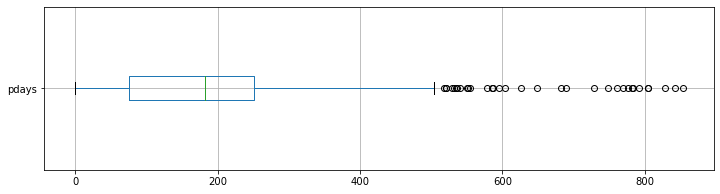

In [61]:
df.boxplot('pdays', figsize=(12,3), vert=False)

<AxesSubplot:>

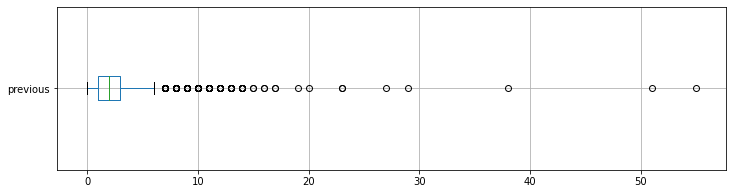

In [62]:
df.boxplot('previous', figsize=(12,3), vert=False)

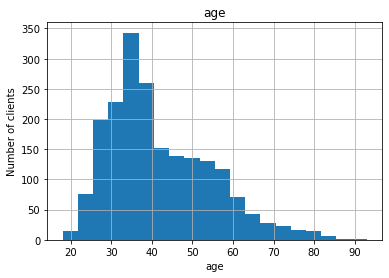

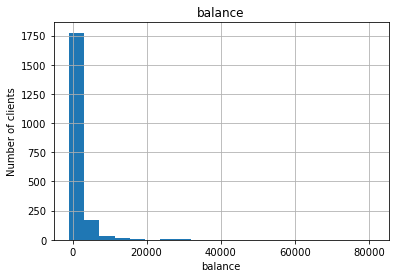

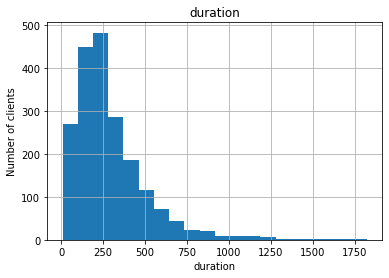

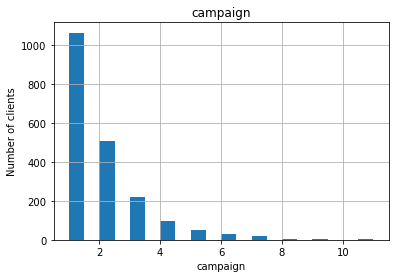

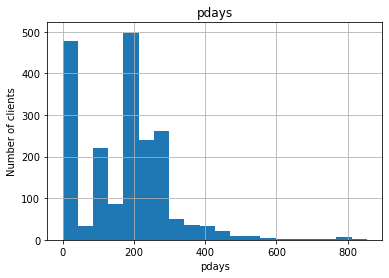

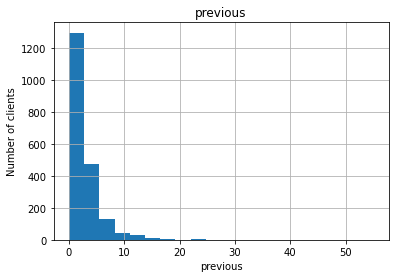

In [63]:
def plotHistograms(group):
    for feat in group:
        plt.title(feat)
        plt.xlabel(feat)
        plt.ylabel('Number of clients')
        df[feat].hist(bins=20)
        plt.show()

df_numeric = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

plotHistograms(df_numeric)

For some of the features plotted above, we can see the presence of significant outliers. For such features we will use RobustScaler for rescaling, as it does a better job in the presence of outliers. RobustScaler transforms each value in a column by subtracting the median from it and then dividing by the interquartile range. 

In [64]:
rs_features = ['balance', 'duration']
robust_scaler = RobustScaler()
df[rs_features] = robust_scaler.fit_transform(df[rs_features])

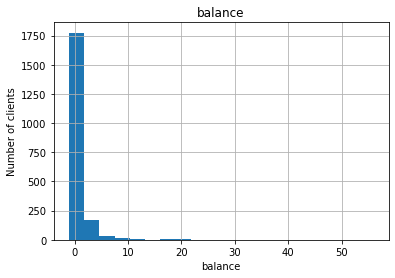

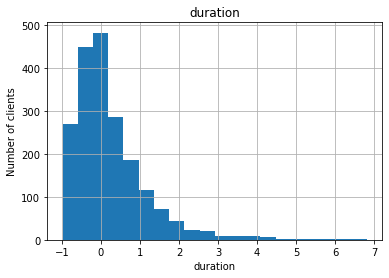

In [65]:
for rs_feat in rs_features:
    plt.title(rs_feat)
    plt.xlabel(rs_feat)
    plt.ylabel('Number of clients')
    df[rs_feat].hist(bins=20)
    plt.show()

For the features that we have just rescaled, the histograms are skewed to the left. Many ML algorithms work better with features that are more normally distributed. In order to address this we will need to handle the outliers.

Firstly, let's check the range of values for these features.

In [66]:
print(df[rs_features].min())
print(df[rs_features].max())

balance    -1.060984
duration   -0.982833
dtype: float64
balance     55.892585
duration     6.811159
dtype: float64


We can see that there are negative values in each feature after rescaling so we will need to add a constant to all values in order to shift them to a positive range. Then we can apply a log transformation to handle the outliers.

In [67]:
# Use a log transformation to decrease the impact of outliers
df['balance'] = np.log(df['balance']+2.07)
df['duration'] = np.log(df['duration']+2)

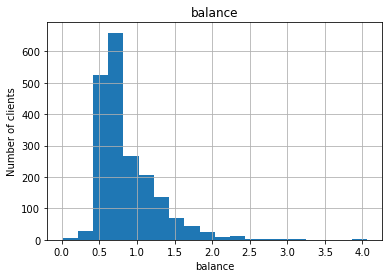

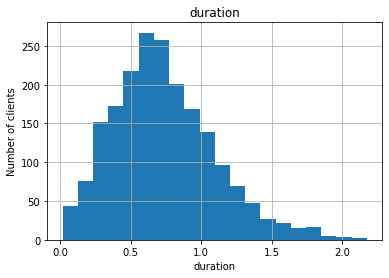

In [68]:
plotHistograms(rs_features)

In the plots above, we can see that the rescaled features now have a less skewed distribution than previously.

Next we need to handle rescaling of some of the other numeric features. We can rescale the pdays feature significantly quite easily by expressing it in terms of years. We will still retain the -1 value, which we believe to mean that a client was not contacted in a previous campaign.  

In [69]:
df['pdays'] = df['pdays'].apply(lambda pd : (pd + 1)/365 if pd > -1 else -1)

In [70]:
print(f'pdays range is now { df.pdays.min() } to { df.pdays.max() }')

pdays range is now -1.0 to 2.3424657534246576


For age normalisation we will use min-max scaling. This means that the minimum age will be transformed to 0, and the maximum age will be transformed to 1. Ages in between will be transformed into a decimal between 0 and 1 accordingly.

In [71]:
minmax_age = (df.age - df.age.min()) / (df.age.max() - df.age.min())
df.age = minmax_age

In [72]:
print(f'age range is now { df.age.min() } to { df.age.max() }')

age range is now 0.0 to 1.0


In [73]:
df.head()

age   balance  duration  campaign     pdays  previous   day_sin  \
0  0.186667  0.672849  1.628146         2  0.361644         2  0.201299   
1  0.280000  0.772393  0.686689         2  0.367123         1  0.201299   
2  0.546667  0.877721  0.423892         2  0.657534         1  0.201299   
3  0.386667  0.674968  0.771538         1  0.654795         2  0.201299   
4  0.480000  0.868750  1.112817         1  0.843836         1  0.201299   

   day_cos  month_sin  month_cos  ...  default_nan  housing_yes  housing_nan  \
0  0.97953   0.866025        0.5  ...            0            1            0   
1  0.97953   0.866025        0.5  ...            0            1            0   
2  0.97953   0.866025        0.5  ...            0            1            0   
3  0.97953   0.866025        0.5  ...            0            1            0   
4  0.97953   0.866025        0.5  ...            0            1            0   

   loan_yes  loan_nan  poutcome_other  poutcome_success  poutcome_nan  \
0         0         0               0                 0             0   
1         1         0               0                 0             0   
2         1         0               0                 0             0   
3         1         0               0                 0             0   
4         0         0               0                 0             0   

   subscribed_yes  subscribed_nan  
0               0               0  
1               0               0  
2               0               0  
3               0               0  
4               0               0  

[5 rows x 38 columns]

# 5. Derived features
There are 2 features in the data, **campaign** and **previous** that both record how many times a client was contacted. These may be candidates from which to derive a new feature.

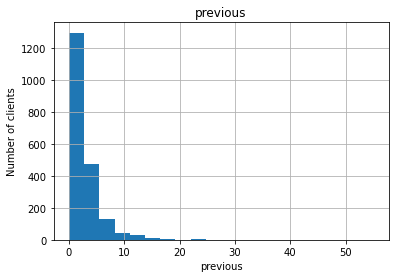

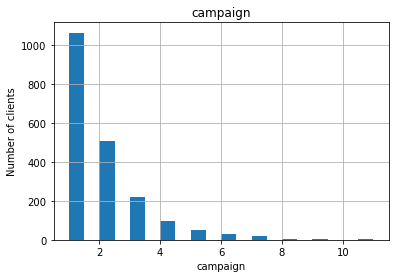

In [74]:
plotHistograms(['previous', 'campaign'])

Let's view the same features grouped by whether subscribed.

In [75]:
grouped = df_original.groupby('subscribed', axis=0)

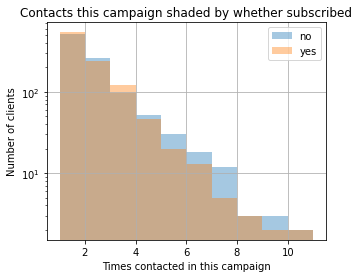

In [76]:
plt.figure(figsize=(5,4))
grouped.campaign.hist(alpha=0.4)
plt.title('Contacts this campaign shaded by whether subscribed')
plt.xlabel('Times contacted in this campaign')
plt.ylabel('Number of clients')
plt.yscale('log')
plt.legend(['no', 'yes'])

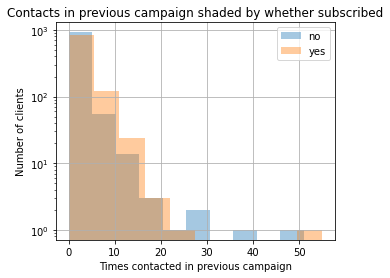

In [77]:
plt.figure(figsize=(5,4))
grouped.previous.hist(alpha=0.4)
plt.title('Contacts in previous campaign shaded by whether subscribed')
plt.xlabel('Times contacted in previous campaign')
plt.ylabel('Number of clients')
plt.yscale('log')
plt.legend(['no', 'yes'])

It appears that we can fairly safely combine these features into a single feature representing the total number of times a client was contacted across this and previous campaigns.

In [79]:
df['totalcontacts'] = df_original['campaign'] + df_original['previous']

Rescale totalcontacts to be between 0 and 1.

In [80]:
tc_max = df['totalcontacts'].max()
df['totalcontacts'] = df['totalcontacts'].apply(lambda tc : tc/tc_max)

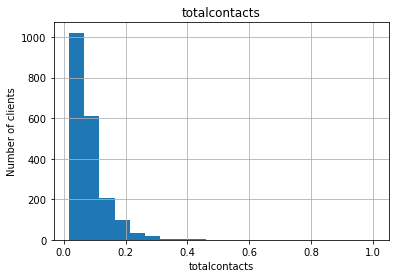

In [81]:
plotHistograms(['totalcontacts'])

# 6. Drop unwanted or replaced features

In [82]:
df.drop('campaign', axis=1, inplace=True)
df.drop('previous', axis=1, inplace=True)

In [83]:
df.head()

age   balance  duration     pdays   day_sin  day_cos  month_sin  \
0  0.186667  0.672849  1.628146  0.361644  0.201299  0.97953   0.866025   
1  0.280000  0.772393  0.686689  0.367123  0.201299  0.97953   0.866025   
2  0.546667  0.877721  0.423892  0.657534  0.201299  0.97953   0.866025   
3  0.386667  0.674968  0.771538  0.654795  0.201299  0.97953   0.866025   
4  0.480000  0.868750  1.112817  0.843836  0.201299  0.97953   0.866025   

   month_cos  job_blue-collar  job_entrepreneur  ...  housing_yes  \
0        0.5                0                 0  ...            1   
1        0.5                0                 0  ...            1   
2        0.5                0                 0  ...            1   
3        0.5                1                 0  ...            1   
4        0.5                0                 0  ...            1   

   housing_nan  loan_yes  loan_nan  poutcome_other  poutcome_success  \
0            0         0         0               0                 0   
1            0         1         0               0                 0   
2            0         1         0               0                 0   
3            0         1         0               0                 0   
4            0         0         0               0                 0   

   poutcome_nan  subscribed_yes  subscribed_nan  totalcontacts  
0             0               0               0       0.068966  
1             0               0               0       0.051724  
2             0               0               0       0.051724  
3             0               0               0       0.051724  
4             0               0               0       0.034483  

[5 rows x 37 columns]

## Note on encoded columns
There is a natural colinearity between columns encoded by *onehotencoder* (e.g. **housing_yes** and **housing_nan**). If the dataset is to be used in a linear regression model, for example, it may be worthwhile dropping a redundant column from such encoded values.

# 6. Save the dataset

In [84]:
df.to_csv('bank_data_prepared.csv')